### Module imports

In [4]:
# Import modules

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import concat
import joblib
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.saving import save_model
from keras.models import load_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from modAL.models import ActiveLearner
from math import sqrt

### Data import

In [5]:
# Read data into DataFrames

# These two groups of data will be used for label making
# Emissions data
nrg_emi_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="CO2 Emissions from Energy", header=2, index_col=0)
# The sheet called "Natural Gas Flaring" is already a part of the calculations for the sheet called "CO2 from Flaring"
flar_emi_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="CO2 from Flaring", header=2, index_col=0)
equi_emi_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="CO2e Methane, Process emissions", header=2, index_col=0)

# Renewable energy production data
hydro_pro_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Hydro Generation - TWh", header=2, index_col=0)
solar_pro_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Solar Generation - TWh", header=2, index_col=0)
wind_pro_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Wind Generation - TWh", header=2, index_col=0)
geo_pro_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Geo Biomass Other - TWh", header=2, index_col=0)
bio_pro_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Biofuels production - PJ", header=2, index_col=0, nrows=47)

# These three groups of data will be used for the feature sets
# Renewable energy consumption data
hydro_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Hydro Consumption - EJ", header=2, index_col=0)
solar_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Solar Consumption - EJ", header=2, index_col=0)
wind_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Wind Consumption - EJ", header=2, index_col=0)
geo_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Geo Biomass Other - EJ", header=2, index_col=0)
bio_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Biofuels consumption - PJ", header=2, index_col=0, nrows=47)

# Non-renewable energy consumption data
oil_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Oil Consumption - EJ", header=2, index_col=0)
gas_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Gas Consumption - EJ", header=2, index_col=0)
coal_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Coal Consumption - EJ", header=2, index_col=0)
nuc_con_df = pd.read_excel(io="data/dataset/Statistical Review of World Energy Data.xlsx", sheet_name="Nuclear Consumption - EJ", header=2, index_col=0)

### Programmatic data processing

In [6]:
def processData(df:pd.DataFrame, flag=False):
    """
    Get an excel sheet ready for conversion to numpy arrays.

    Parameters:
    - df (pd.DataFrame): a dataframe containing an excel sheet
    - flag (boolean): an indicator to convert PJ to EJ instead of kWh
    """
    #------------------------------ 
    # Remove all irrelevant columns
    #------------------------------

    # Remove all data from before 1990
    # Find the index of the "1990" column
    drop_indx = list(df.columns).index(1990)
    # Get the column labels of all columns left of "1990"
    drop_cols = [df.columns[num] for num in np.arange(0, drop_indx)]
    df = df.drop(columns=drop_cols)

    # Remove data on growth-rate and share
    # Get the column labels of the target columns
    drop_cols = [df.columns[num] for num in [-3, -2, -1]]
    df = df.drop(columns=drop_cols)

    #---------------------------
    # Remove all irrelevant rows
    #---------------------------

    # Remove all rows with any empty cells
    # 0 doesn't make an empty cell
    df = df.dropna()

    # Remove all "Total" and "Other" rows
    # In addition, OECD, Non-OECD, the EU, and the USSR
    # In addition, 8 other countries because they only appear in excel sheets for
    # flaring emissions and nothing else. I can't make data samples for non-existent data
    # Rationale for removing "Other" rows - some countries in some excel sheets appear
    # individually, but are lumped into an "Other" row in other sheets.
    # There's no possible way for me to know which portions of an
    # "Other" row value belongs to which countries.
    drop_rows = []
    keywords = ["Total", "Other", "OECD", "European Union", "USSR", "Bolivia", 
                "Bahrain", "Syria", "Yemen", "Libya", "Nigeria", "Brunei", "Myanmar"]
    for row in df.index:
        # Mark a row for dropping if it contains any of the keywords
        if any(keyword in row for keyword in keywords):
            drop_rows.append(row)
    df = df.drop(index=drop_rows)

    # -----------------
    # Convert the units
    # -----------------

    # This section is only performed on emissions data, 
    # renewable energy production data, and consumed
    # biofuel energy data
    # All other dataframes have "Exajoules" as their name
    
    # All CO2 data is currently represented as millions of tonnes
    # Convert all produced renewable data to kilowatt-hour (kWh)
    # 1 kWh = 3600 kJ
    # 1 PJ = 1000000000000 kJ
    # 1 TWh = 1000000000 kWh

    if (df.index.name) == "Million tonnes of carbon dioxide":
        # Convert to single tonnes
        df = df * 1000000
    elif df.index.name == "Terawatt-hours":
        # Convert to kilowatt-hours
        df = df * 1000000000
    elif df.index.name == "Petajoules":
        if flag:
            # Convert to exajoules
            df = df * 0.001
        else:
            # Convert to kilowatt-hours
            df = df * (1000000000000/3600)

    return df

# tonnes = metric ton = 1000 kg


In [7]:
def rowIndices(df:pd.DataFrame):
    """
    Return the row labels of a pd.DataFrame

    Parameters:
    - df (pd.DataFrame): a dataframe containing an excel sheet
    """

    return [row for row in df.index]


In [8]:
# Process dataframes

# Unit: Tonnes
nrg_emi_df = processData(nrg_emi_df)
flar_emi_df = processData(flar_emi_df)
equi_emi_df = processData(equi_emi_df)

# Unit: Kilowatt-hours
hydro_pro_df = processData(hydro_pro_df)
solar_pro_df = processData(solar_pro_df)
wind_pro_df = processData(wind_pro_df)
geo_pro_df = processData(geo_pro_df)
bio_pro_df = processData(bio_pro_df)

# Unit: Exajoules
hydro_con_df = processData(hydro_con_df)
solar_con_df = processData(solar_con_df)
wind_con_df = processData(wind_con_df)
geo_con_df = processData(geo_con_df)
bio_con_df = processData(bio_con_df, True)

# Unit: Exajoules
oil_con_df = processData(oil_con_df)
gas_con_df = processData(gas_con_df)
coal_con_df = processData(coal_con_df)
nuc_con_df = processData(nuc_con_df)

In [9]:
# Convert to numpy arrays

nrg_emi = nrg_emi_df.to_numpy()
flar_emi = flar_emi_df.to_numpy()
equi_emi = equi_emi_df.to_numpy()
hydro_p = hydro_pro_df.to_numpy()
solar_p = solar_pro_df.to_numpy()
wind_p = wind_pro_df.to_numpy()
geo_p = geo_pro_df.to_numpy()
bio_p = bio_pro_df.to_numpy()

hydro_c = hydro_con_df.to_numpy()
solar_c = solar_con_df.to_numpy()
wind_c = wind_con_df.to_numpy()
geo_c = geo_con_df.to_numpy()
bio_c = bio_con_df.to_numpy()
oil_c = oil_con_df.to_numpy()
gas_c = gas_con_df.to_numpy()
coal_c = coal_con_df.to_numpy()
nuc_c = nuc_con_df.to_numpy()

# print(len(rowIndices(hydro_con_df)), len(rowIndices(solar_con_df)), len(rowIndices(wind_con_df)), len(rowIndices(geo_con_df)), len(rowIndices(bio_con_df)))
# print(len(rowIndices(oil_con_df)), len(rowIndices(gas_con_df)), len(rowIndices(coal_con_df)), len(rowIndices(nuc_con_df)))
# print(len(rowIndices(tol_con_df)))

# Get row indices of dataframes
# There are three unique indices/list of countries

# All of these dataframes (and their NDarray equivalents) have 83 indices.
# Their row indices are shown in nrg_emi_indices
#
# nrg_emi_df
# equi_emi_df
# hydro_pro_df
# solar_pro_df
# wind_pro_df
# geo_pro_df
# hydro_con_df
# solar_con_df
# wind_con_df
# geo_con_df
# oil_con_df
# gas_con_df
# coal_con_df
# nuc_con_df

# All of these dataframes (and their NDarray equivalents) have 41 indices
# Their row indices are shown in flar_emi_indices
# 
# flar_emi_df

# All of these dataframes (and their NDarray equivalents) have 24 indices
# Their row indices are shown in bio_indices
#
# bio_pro_df
# bio_con_df

# The rest of the dataframes share the same index list as nrg_emi_indices
nrg_emi_indices = rowIndices(nrg_emi_df)
flar_emi_indices = rowIndices(flar_emi_df)
bio_indices = rowIndices(bio_pro_df)

<b>nrg_emi_indices:</b>

['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela', 'Central America', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom', 'Azerbaijan', 'Belarus', 'Kazakhstan', 'Russian Federation', 'Turkmenistan', 'Uzbekistan', 'Iran', 'Iraq', 'Israel', 'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 'United Arab Emirates', 'Algeria', 'Egypt', 'Morocco', 'South Africa', 'Eastern Africa', 'Middle Africa', 'Western Africa', 'Australia', 'Bangladesh', 'China', 'China Hong Kong SAR', 'India', 'Indonesia', 'Japan', 'Malaysia', 'New Zealand', 'Pakistan', 'Philippines', 'Singapore', 'South Korea', 'Sri Lanka', 'Taiwan', 'Thailand', 'Vietnam']

<b>flar_emi_indices:</b>

['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Colombia', 'Peru', 'Trinidad & Tobago', 'Venezuela', 'Denmark', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Poland', 'Romania', 'Ukraine', 'United Kingdom', 'Azerbaijan', 'Kazakhstan', 'Russian Federation', 'Turkmenistan', 'Uzbekistan', 'Iran', 'Iraq', 'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 'United Arab Emirates', 'Algeria', 'Egypt', 'Australia', 'Bangladesh', 'China', 'India', 'Indonesia', 'Malaysia', 'Pakistan', 'Thailand', 'Vietnam']

<b>biofuel_indices:</b>

['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Colombia', 'Austria', 'Belgium', 'Finland', 'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Spain', 'Sweden', 'United Kingdom', 'Australia', 'China', 'India', 'Indonesia', 'South Korea', 'Thailand']

<b>Shape of nrg_emi:</b>

(83, 33)

<b>Columns of every dataframe:</b>

Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='object')


In [10]:
# Massive 3D numpy array for label making
# 1st dimension - Years. 33 years from 1990-2022 (inclusive)
# 2nd dimension - Countries/Regions. 83 unique countries/regions
# 3rd dimension - Carbon Neutral features. 8 features (in this order): energy emissions, flaring emissions, CO2 equivalent emissions, 
# hydroelectric production, solar production, wind production, geothermal production, biofuel production
# (33, 83, 8)

# Find every unique country/region
# This is a bit redundant because every country in flar_emi_indices and bio_indices 
# is already in nrg_emi_indices
cotry_reg = list(set(nrg_emi_indices + flar_emi_indices + bio_indices))
cotry_reg.sort()
print(cotry_reg)

dim_1 = []
for year_indx in range(33):
    dim_2 = []
    for area in cotry_reg:
        # There's no area check for the upcoming data
        # because every area has this data
        indx = nrg_emi_indices.index(area)
        # Extract a float
        a_nrg_emi = nrg_emi[indx][year_indx]
        a_equi_emi = equi_emi[indx][year_indx]
        a_hydro = hydro_p[indx][year_indx]
        a_solar = solar_p[indx][year_indx]
        a_wind = wind_p[indx][year_indx]
        a_geo = geo_p[indx][year_indx]

        if area in flar_emi_indices:
            indx = flar_emi_indices.index(area)
            # Extract a float
            a_flar_emi = flar_emi[indx][year_indx]
        else:
            a_flar_emi = 0.

        if area in bio_indices:
            indx = bio_indices.index(area)
            # Extract a float
            a_biofuel = bio_p[indx][year_indx]
        else:
            a_biofuel = 0.

        # Is also a set of features
        dim_3 = [a_nrg_emi,
                a_flar_emi,
                a_equi_emi,
                a_hydro,
                a_solar,
                a_wind,
                a_geo,
                a_biofuel]
        dim_2.append(dim_3)
    dim_1.append(dim_2)

# Label Statistical Review 
# Full of floats
lsr = np.array(dim_1)
print(f"lsr shape: {lsr.shape}")


['Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Brazil', 'Bulgaria', 'Canada', 'Central America', 'Chile', 'China', 'China Hong Kong SAR', 'Colombia', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Eastern Africa', 'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Kuwait', 'Latvia', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Middle Africa', 'Morocco', 'Netherlands', 'New Zealand', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russian Federation', 'Saudi Arabia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Trinidad & Tobago', 'Turkey', 'Turkmenistan', 'US', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uzbekistan', 'Venezu

In [11]:
# Massive 3D numpy array for classification
# 1st dimension - Years. 33 years from 1990-2022 (inclusive)
# 2nd dimension - Countries/Regions. 83 unique countries/regions
# 3rd dimension - Energy Consumption features. 9 features (in this order): oil, gas, coal, nuclear, 
# hydroelectric, solar, wind, geothermal, biofuel
# (33, 83, 9)

print(cotry_reg)

dim_1 = []
for year_indx in range(33):
    dim_2 = []
    for area in cotry_reg:
        # There's no area check for the upcoming data
        # because every area has this data
        indx = nrg_emi_indices.index(area)
        # Extract a float
        a_hydro = hydro_c[indx][year_indx]
        a_solar = solar_c[indx][year_indx]
        a_wind = wind_c[indx][year_indx]
        a_geo = geo_c[indx][year_indx]
        a_oil = oil_c[indx][year_indx]
        a_gas = gas_c[indx][year_indx]
        a_coal = coal_c[indx][year_indx]
        a_nuc = nuc_c[indx][year_indx]

        if area in bio_indices:
            indx = bio_indices.index(area)
            # Extract a float
            a_biofuel = bio_c[indx][year_indx]
        else:
            a_biofuel = 0.

        # Is also a set of features
        dim_3 = [a_oil, a_gas, a_coal, a_nuc,
                 a_hydro, a_solar, a_wind, a_geo, a_biofuel]
        dim_2.append(dim_3)
    dim_1.append(dim_2)

# Classification Statistical Review 
# Full of floats
csr = np.array(dim_1)
print(f"csr shape: {csr.shape}")

# Concatenated version
ccsr = np.concatenate(csr, axis=0)
print(f"ccsr shape: {ccsr.shape}") 

['Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Brazil', 'Bulgaria', 'Canada', 'Central America', 'Chile', 'China', 'China Hong Kong SAR', 'Colombia', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Eastern Africa', 'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Kuwait', 'Latvia', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Middle Africa', 'Morocco', 'Netherlands', 'New Zealand', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russian Federation', 'Saudi Arabia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Trinidad & Tobago', 'Turkey', 'Turkmenistan', 'US', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uzbekistan', 'Venezu

In [12]:
def makeLabel(features):
    """
    Make a label for a sample

    - features (np.ndarray): set of 8 features
    """
    # Unit: Tonnes of Carbon Dioxide
    co2 = np.sum(features[:3])
    # Unit: Kilowatt-hours
    renewable = np.sum(features[3:])

    # Electricity reductions emission factor
    # 0.000709 tonnes CO2/kWh
    # Unit: Tonnes of Carbon Dioxide
    renewable *= 0.000709

    # Remaining co2 after being offset by renewable energy production
    rem_co2 = max(co2 - renewable, 0)

    if rem_co2 == 0:
        return 0
    else:
        percent = (rem_co2/co2) * 100
        # Equivalent to np.floor(percent / 10)
        # The label is the tens place of the percentage
        # return int(np.floor(percent / 10))
        if percent > 0.0 and percent <= 20.0:
            label = 1
        elif percent > 20.0 and percent <= 40.0:
            label = 2
        elif percent > 40.0 and percent <= 60.0:
            label = 3
        elif percent > 60.0 and percent <= 80.0:
            label = 4
        elif percent > 80.0 and percent <= 100.0:
            label = 5
        else:
            label = 5
        return label


In [13]:
# Make labels for all of the data/samples/examples 
# An individual feature isn't a example, but a location in a particular year is
# Thus, there are 33 * 83 = 2739 examples

# There are 6 possible labels, 0-5
# 0 means carbon neutral is achieved
# 5 means the country is absolutely nowhere near carbon neutrality
labels = np.array([[makeLabel(location) for location in year] for year in lsr])
print(f"labels shape: {labels.shape}")

# Concatenated version
clabels = np.concatenate(labels, axis=0)
print(f"clabels shape: {clabels.shape}")

labels shape: (33, 83)
clabels shape: (2739,)


In [14]:
# Split the big dataset into a three subsets: labeled training, unlabeled training, and test

# Labeled training subset
# Years 1990-1991
lab_set = csr[0:2]
lab_set_label = labels[0:2]

# Unlabeled training subset
# aka Pool
# Years 1992-2020
unlab_set = csr[2:31]
unlab_set_label = labels[2:31]

# Test subset
# Years 2021-2022
test_set = csr[31::]
test_set_label = labels[31::]


# Concatenated versions
clab_set = np.concatenate(lab_set, axis=0)
clab_set_label = np.concatenate(lab_set_label, axis=0)

cunlab_set = np.concatenate(unlab_set, axis=0)
cunlab_set_label = np.concatenate(unlab_set_label, axis=0)

ctest_set = np.concatenate(test_set, axis=0)
ctest_set_label = np.concatenate(test_set_label, axis=0)


print("Labeled training subset, Years 1990-1991")
print(f"lab_set shape: {lab_set.shape}")
print(f"lab_set_label shape: {lab_set_label.shape}")
print(f"clab_set shape: {clab_set.shape}")
print(f"clab_set_label shape: {clab_set_label.shape}\n")

print("Unlabeled training subset, Years 1992-2020")
print(f"unlab_set shape: {unlab_set.shape}")
print(f"unlab_set_label shape: {unlab_set_label.shape}")
print(f"cunlab_set shape: {cunlab_set.shape}")
print(f"cunlab_set_label shape: {cunlab_set_label.shape}\n")

print("Test subset, Years 2021-2022")
print(f"test_set shape: {test_set.shape}")
print(f"test_set_label shape: {test_set_label.shape}")
print(f"ctest_set shape: {ctest_set.shape}")
print(f"ctest_set_label shape: {ctest_set_label.shape}")

Labeled training subset, Years 1990-1991
lab_set shape: (2, 83, 9)
lab_set_label shape: (2, 83)
clab_set shape: (166, 9)
clab_set_label shape: (166,)

Unlabeled training subset, Years 1992-2020
unlab_set shape: (29, 83, 9)
unlab_set_label shape: (29, 83)
cunlab_set shape: (2407, 9)
cunlab_set_label shape: (2407,)

Test subset, Years 2021-2022
test_set shape: (2, 83, 9)
test_set_label shape: (2, 83)
ctest_set shape: (166, 9)
ctest_set_label shape: (166,)


### Batch Active Learning

#### Classification Plan
- Baseline train phase: Train the classifier on all the labeled data, it's supervised learning
- 1st Training phase: Train a new classifier on the first two labeled years of the data
- 2nd Training phase: Use the classifier and batch active learning on the rest of the unlabeled data until 2021. Examples that would provide the most information will be chosen to get their true label and taught to the classifier
- 1st Evaluate phase: Use the newly trained classifier to evaluate the data from 2021 and 2022
- Predict phase (Predict plan): Use time series forecasting to predict a country's set of features until 2050
- 2nd Evaluate phase: Use the classifier to predict levels of CN
- Baseline Evaluate phase: Use the baseline classifier to predict levels of CN

In [15]:
# Classifier parameters
# These are different from real model parameters that are estimated by the model itself

n_estimators = 500
criterion = "log_loss"
max_depth = 25

In [16]:
# Baseline phase: Train the classifier on all the labeled data, it's supervised learning

path = "models/bal/learners/baseline.pkl"

if not os.path.exists(path):
    baseline = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)

    # Combine all labeled and unlabeled data
    baseline_data = np.concatenate((clab_set, cunlab_set), axis=0)
    baseline_labels = np.concatenate((clab_set_label, cunlab_set_label), axis=0)
    # baseline_data.shape = (2573, 9)
    # baseline_labels.shape = (2573,)

    baseline.fit(baseline_data, baseline_labels)
    print(f"Baseline model training accuracy: {baseline.score(ccsr, clabels)}")

    joblib.dump(baseline, path)
else:
    baseline = joblib.load(path)

print(f"Baseline model accuracy on test data: {baseline.score(ctest_set, ctest_set_label)}")

Baseline model accuracy on test data: 0.8493975903614458


In [17]:
# Batch Active Learning
def batch_active_learning(classifier: ActiveLearner, unlab_data, unlab_lab, all_data, all_labels, n_queries):
    """Train a classifier using batch active learning
    
    Parameters:
    - classifier (ActiveLearner): a classifier from the scikit-learn (sklearn) module 
    - unlab_data (ndarray): the unlabeled dataset, shape=(29, 83, 9)
    - unlab_lab (ndarray): the unlabled dataset's labels, shape=(29, 83)
    - add_data (ndarray): all data in concatenated form, shape=(2739, 9)
    - all_labels (ndarray): all data labels in concatenated form, shape=(2739,)
    - n_queries (int): number of queries to make on each year of data
    """

    count = 1
    for year_data, year_label in zip(unlab_data, unlab_lab):
        # year_data.shape = (83, 9)
        # year_label.shape = (83,)
        for _ in range(n_queries):
            # Query based on uncertainty
            query_index, _ = classifier.query(year_data)

            # Retrieve the requested example and its label, and teach it to the classifier
            example = year_data[query_index].reshape(1, -1)
            example_label = year_label[query_index].reshape(1,)
            # example.shape = (1, 9)
            # example_label.shape = (9,)
            classifier.teach(X=example, y=example_label)

            # Remove the queried example and its label from the unlabeled datasets
            year_data = np.delete(year_data, query_index, axis=0)
            year_label = np.delete(year_label, query_index)

            accuracy = classifier.score(all_data, all_labels)
            print(f"Accuracy after query {count}: {round(accuracy, 4)}")

            count += 1
    

In [18]:
# Batch active learning hyperparameters aka model parameters
# These are different from real model parameters that are estimated by the model itself

n_queries = 10

In [19]:
# 1st Training phase: Train a classifier on the first two labeled years of the data
# 2nd Training phase: Use the classifier and batch active learning on the rest of the unlabeled data until 2021. Examples that would provide the most 

path = "models/bal/learners/al_rand_forest7.pkl"

if not os.path.exists(path):
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)

    # Start the classifier off by training it on the labeled dataset
    classifier = ActiveLearner(estimator=rf, X_training=clab_set, y_training=clab_set_label)

    batch_active_learning(classifier, np.copy(unlab_set), np.copy(unlab_set_label), ccsr, clabels, n_queries)

    joblib.dump(classifier, path)

In [20]:
# 1st Evaluate phase: Use the newly trained classifier to evaluate the data from 2021 and 2022
clf = joblib.load("models/bal/learners/al_rand_forest7.pkl")
accuracy = clf.score(ctest_set, ctest_set_label)
print(f"Model accuracy on test data: {accuracy}")

Model accuracy on test data: 0.8554216867469879


### Time Series Forecasting

In [21]:
# Predict phase (Predict plan): Use time series forecasting to predict a country's set of features until 2050

#### Predict Plan
- 1st data processing phase: Separate data by country/region instead of by feature. For each country/region, split their data into 3/4 and 1/4, where 3/4 is the training set and 1/4 is the test set
- Training forecast phase: For each country/region, apply a LSTM RNN model on the training data and test data
- Evaluate phase: For each country/region, evaluate the validity of the model's forecasts
- 2nd data processing phase: Keep the data intact as a whole, but make sure it's normalized
- Final fitting phase: Make new models that are fitted on all of their country's data
- Real forecast phase: For each country/region, make forecasts of the features for 2023-2050

In [22]:
# A function to create new framings of time series problems given a desired length of inout and output sequences
# This was taken from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [23]:
# 1st data processing phase: Separate data by country/region instead of by feature.

# csr before: a list of snapshots of the world, with each snapshot showing countries' features during a particaulr year
print(f"csr shape: {csr.shape}")
# *_tsf after: a list of countries, with each country entry containing only their features throughout the years
all_tsf = np.transpose(csr, [1, 0, 2])
# train_tsf = np.transpose(csr[0:25], [1, 0, 2])
# test_tsf = np.transpose(csr[25:], [1, 0, 2])

print("Time span: 1990-2022")
print(f"all_tsf shape: {all_tsf.shape}")
# print("Time span: 1990-2014")
# print(f"train_tsf shape: {train_tsf.shape}")
# print("Time span: 2015-2022")
# print(f"test_tsf shape: {test_tsf.shape}")


csr shape: (33, 83, 9)
Time span: 1990-2022
all_tsf shape: (83, 33, 9)


In [24]:
# Data processing for time series forecasting

scaler = MinMaxScaler(feature_range=(0, 1))
train_tsf = []
test_tsf = []
for country in all_tsf:
    country_df = DataFrame(country, columns=["Oil", "Gas", "Coal", "Nuclear", 
                                             "Hydro", "Solar", "Wind", "Geothermal", "Biofuel"])
    # country_df.shape = (33, 9), 33 rows and 9 columns

    # Normalize features for LSTM
    scaled = scaler.fit_transform(country_df.values)
    # scaled.shape = (33, 9)

    # For each country/region, split their data into 3/4 and 1/4, 
    # where 3/4 is the training set and 1/4 is the test set
    train = scaled[:25]
    test = scaled[25:]

    # Recall that the # of years dimension decreases by 1
    # in series_to_supervised()
    reframed_train = series_to_supervised(train).values
    reframed_test = series_to_supervised(test).values
    # reframed_*.shape = (# of years, 18), # of years rows and 18 columns
    # columns 0-8: t-1 for each feature
    # columns 9-17: t for each feature

    train_tsf.append(reframed_train)
    test_tsf.append(reframed_test)
    
train_tsf = np.array(train_tsf)
test_tsf = np.array(test_tsf)

print(f"train_tsf shape = {train_tsf.shape}")
print(f"test_tsf shape = {test_tsf.shape}")
    

train_tsf shape = (83, 24, 18)
test_tsf shape = (83, 7, 18)


In [25]:
# Training forecast phase: For each country/region, apply a LSTM RNN model on the training data and test data
# Time series forecast training

for index in range(len(cotry_reg)):
    # Runs for 83 cycles, one cycle for a country

    path = f"models/lstm/train_test/{cotry_reg[index]}_model.keras"
    if os.path.exists(path):
        continue

    print(f"{cotry_reg[index]} model")

    # No putting the model creation code in a separate function
    # I'll get warnings about potential damage
    model = Sequential()
    model.add(LSTM(units=50, return_sequences = True, input_shape=(1, 9)))
    model.add(LSTM(units=50, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(9))
    model.compile(optimizer="adam", loss="mean_absolute_error")

    train: np.ndarray = train_tsf[index]
    # train_tsf.shape = (24, 18)
    train_X, train_y = train[:, :9], train[:, 9:]
    # train_*.shape = (24, 9)

    test: np.ndarray = test_tsf[index]
    # test_tsf.shape = (7, 18)
    test_X, test_y = test[:, :9], test[:, 9:]
    # test_*.shape = (7, 9)

    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
    # train_X.shape = (24, 1, 9)
    # test_X.shape = (7, 1, 9)

    # Fit the network on the training data
    model.fit(train_X, train_y, epochs=50, batch_size=10, 
              validation_data=(test_X, test_y), verbose=0, shuffle=False)

    save_model(model, path)

In [26]:
# Evaluate phase: For each country/region, evaluate the validity of the model's forecasts
# Time series forecast evaluating

rmse = []
if not os.path.exists("data/generated_data/rmse.txt"):
    for index in range(len(cotry_reg)):
        # Runs for 83 cycles, one cycle for a country
        print(f"For {cotry_reg[index]}:")

        path = f"models/lstm/train_test/{cotry_reg[index]}_model.keras"
        model = load_model(path)

        test: np.ndarray = test_tsf[index]
        # test_tsf.shape = (7, 18)
        test_X, test_y = test[:, :9], test[:, 9:]
        # test_*.shape = (7, 9)

        test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
        # test_X.shape = (7, 1, 9)
        
        # Predict on the test data
        yhat = model.predict(test_X, verbose=0)
        # type(yhat) = np.ndarray
        # np.shape(yhat) = (7, 9)

        # Invert the forecast's scaling
        inv_yhat = scaler.inverse_transform(yhat)

        # Invert the real data's scaling
        inv_y = scaler.inverse_transform(test_y)

        # Note: The objective is to MINIMIZE rmse
        rmse.append(sqrt(mean_squared_error(inv_y, inv_yhat)))

    for index in range(len(cotry_reg)):
        print(f"{cotry_reg[index]} rmse: {rmse[index]}")


In [27]:
# 2nd data processing phase: Keep the data intact as a whole, but make sure it's normalized

full_tsf = []
for country in all_tsf:
    country_df = DataFrame(country, columns=["Oil", "Gas", "Coal", "Nuclear", 
                                             "Hydro", "Solar", "Wind", "Geothermal", "Biofuel"])
    # country_df.shape = (33, 9), 33 rows and 9 columns

    # Normalize features for LSTM
    scaled = scaler.fit_transform(country_df.values)
    # scaled.shape = (33, 9)

    # Recall that the # of years dimension decreases by 1
    # in series_to_supervised()
    reframed = series_to_supervised(scaled).values
    # reframed.shape = (# of years, 18), # of years rows and 18 columns
    # columns 0-8: t-1 for each feature
    # columns 9-17: t for each feature

    full_tsf.append(reframed)

full_tsf = np.array(full_tsf)

print(f"full_tsf shape = {full_tsf.shape}")

full_tsf shape = (83, 32, 18)


In [28]:
# Final fitting phase: Make new models that are fitted on all of their country's data

for index in range(len(cotry_reg)):
    # Runs for 83 cycles, one cycle for a country

    path = f"models/lstm/full/full_{cotry_reg[index]}_model.keras"
    if os.path.exists(path):
        continue

    print(f"Full {cotry_reg[index]} model")

    # No putting the model creation code in a separate function
    # I'll get warnings about potential damage
    model = Sequential()
    model.add(LSTM(units=50, return_sequences = True, input_shape=(1, 9)))
    model.add(LSTM(units=50, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(9))
    model.compile(optimizer="adam", loss="mean_absolute_error")

    full: np.ndarray = full_tsf[index]
    # full.shape = (32, 18)
    full_X, full_y = full[:, :9], full[:, 9:]
    # full_*.shape = (32, 9)

    full_X = np.reshape(full_X, (full_X.shape[0], 1, full_X.shape[1]))
    # full_X.shape = (24, 1, 9)

    # Fit the network on all the data
    model.fit(full_X, full_y, epochs=50, batch_size=10, verbose=0, shuffle=False)

    save_model(model, path)

In [29]:
# Real forecast phase: For each country/region, make forecasts of the features for 2023-2050
# 2023-2050 is 28 years, this does count predictions of 2050. 
# The LSTM models are one-step, so each model should run 28 times
# If the models were multi-step, they could run fewer than 28 times, but they're not
# These multiple one-steps align with traditional models of time series forecasting since
# the latter uses a recursive approach for predictions. Meanwhile, machine learning models
# of time series forecasting use a direct approach.

def predict(model: Sequential, data, num_prediction, look_back):
    """Make one-step predictions for an amount of years"""
    prediction_list = data[-look_back:]
    # 28 cycles
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        # x.shape = (15, 1, 9)
        out = model.predict(x, verbose=0)
        # out.shape = (15, 9)
        out = out[-1]
        # out.shape = (9,)
        # Turn negatives into zero
        out = out.clip(min=0)
        out = np.expand_dims(out, axis=[0,1])
        # out.shape = (1, 1, 9)
        prediction_list = np.append(prediction_list, out, axis=0)

    # Remove dimension required for LSTM
    prediction_list = np.reshape(prediction_list, 
                                 (prediction_list.shape[0], prediction_list.shape[2]))
    prediction_list = prediction_list[look_back-1:]
    # Undo normalization
    prediction_list = scaler.inverse_transform(prediction_list)
        
    # predictions_list.shape = (43, 9)  
    return prediction_list

# Years into the future
num_prediction = 28
# aka # of lag observations to use
look_back = 15

forecasts = []
if not os.path.exists("data/generated_data/forecasts.npy"):
    # Runs for 83 cycles
    for index in range(len(cotry_reg)):
        name = cotry_reg[index]
        data = all_tsf[index]
        # data.shape = (33, 9)
        # Normalize data
        data = scaler.fit_transform(data)
        # Reshape for the LSTM model
        data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
        # data.shape = (33, 1, 9)

        path = f"models/lstm/full/full_{name}_model.keras"
        model = load_model(path)

        print(f"Predicting for {name}...")
        forecasts.append(predict(model, data, num_prediction, look_back))

    forecasts = np.array(forecasts)
    print(f"forecasts shape: {forecasts.shape}")
    np.save("data/generated_data/forecasts", forecasts)
else:
    forecasts = np.load("data/generated_data/forecasts.npy")
    print(f"forecasts shape: {forecasts.shape}")


forecasts shape: (83, 29, 9)


          Oil        Gas       Coal   Nuclear     Hydro     Solar      Wind  \
0   33.504887  18.614192  19.216791  6.202814  3.111377  0.003947  0.029985   
1   32.790634  19.022301  19.035408  6.586721  3.058632  0.005091  0.031731   
2   33.470592  19.668635  19.166512  6.653508  2.676467  0.004352  0.031049   
3   33.753761  20.157910  19.880829  6.562271  2.972671  0.005058  0.032321   
4   34.631088  20.631892  19.955317  6.886450  2.760730  0.005343  0.037066   
5   34.551098  21.527386  20.134993  7.240883  3.312985  0.005477  0.034024   
6   35.809700  21.920033  21.050283  7.255146  3.699720  0.005763  0.034775   
7   36.287167  22.051136  21.494801  6.759615  3.789391  0.005671  0.035355   
8   36.904003  21.678447  21.705618  7.244109  3.428692  0.005585  0.032534   
9   37.933533  21.753463  21.672342  7.830689  3.370313  0.005518  0.048258   
10  38.354881  22.622064  22.631531  8.106376  2.903589  0.005520  0.060143   
11  38.292656  21.623689  21.964737  8.213268  2.223

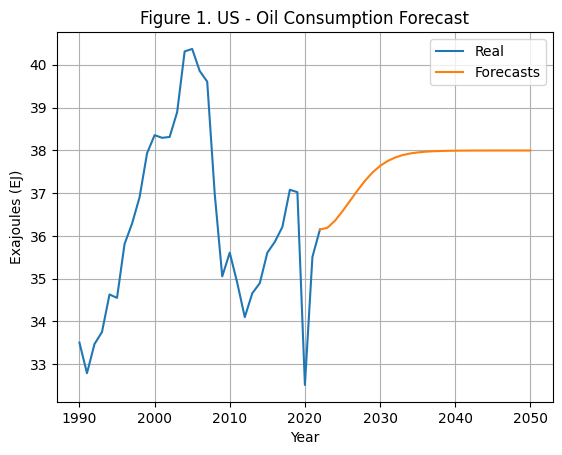

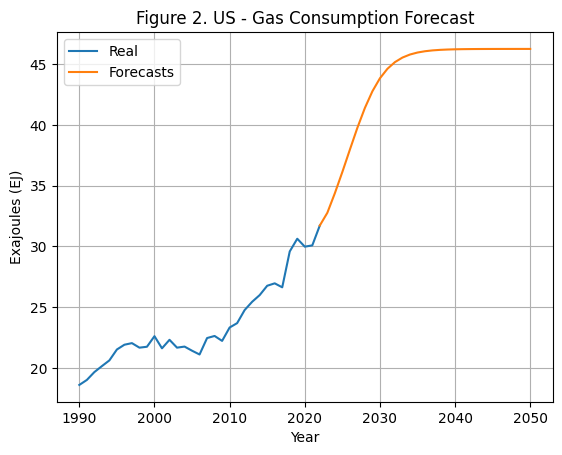

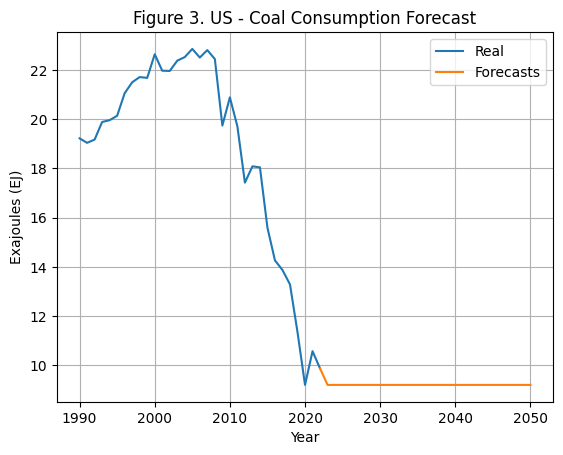

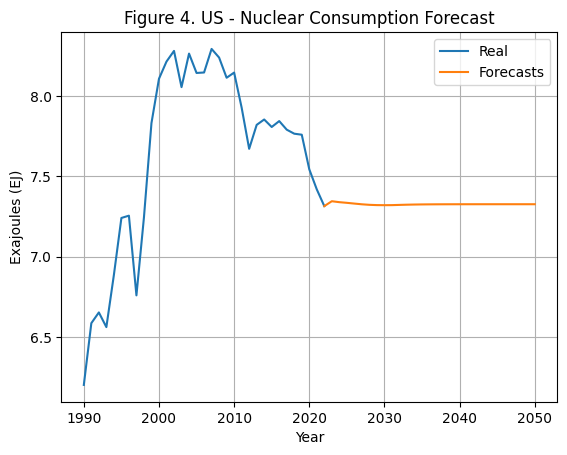

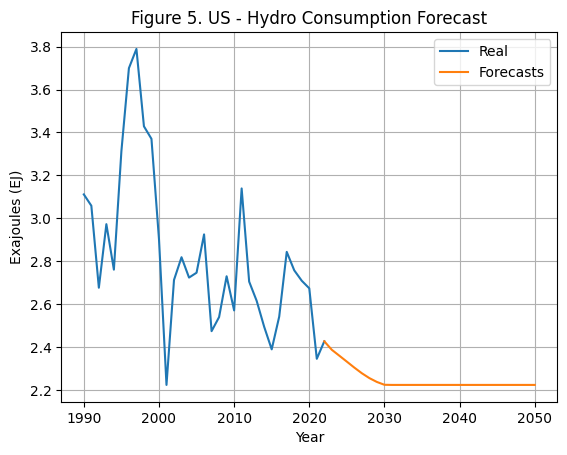

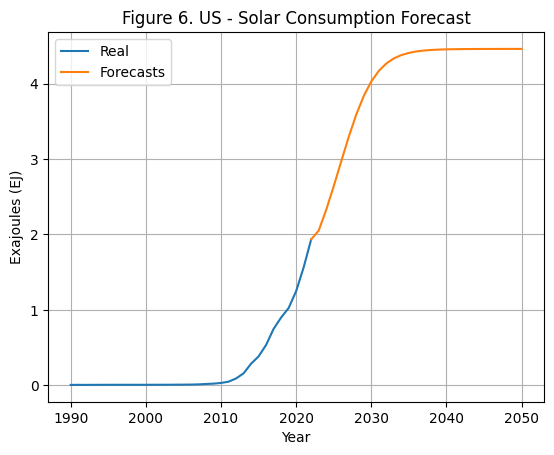

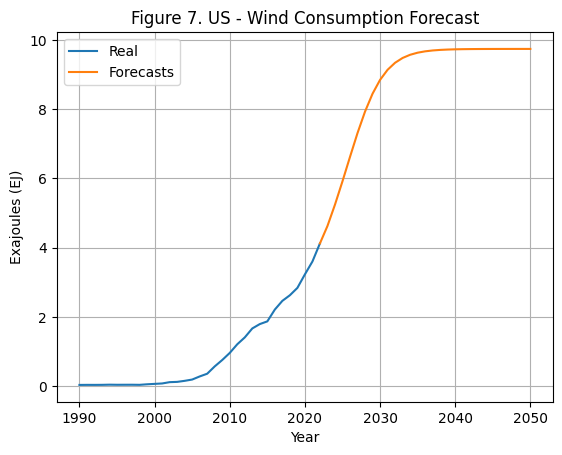

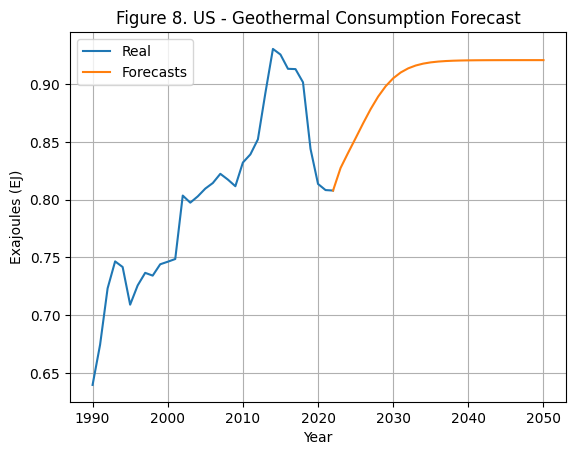

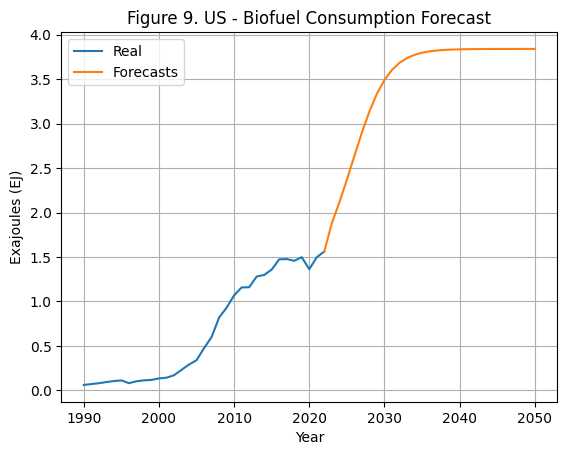

In [43]:
# Display the actual and predicted data

columns = ["Oil", "Gas", "Coal", "Nuclear", "Hydro", "Solar", "Wind", "Geothermal", "Biofuel"]

real_us = DataFrame(all_tsf[75], columns=columns)

pred_us = DataFrame(forecasts[75], columns=columns)

print(real_us)
print()
print(pred_us)

curt_range = np.array(real_us.index) + 1990
futr_range = np.array(pred_us.index) + 2022

for index, feature in enumerate(columns):
    title = f"Figure {index+1}. US - {feature} Consumption Forecast"
    plt.title(title)
    plt.plot(curt_range, real_us[feature], label="Real")
    plt.xlabel("Year")
    plt.plot(futr_range, pred_us[feature], label="Forecasts")
    plt.ylabel("Exajoules (EJ)")
    plt.grid(True, "both", "both")
    plt.legend(loc="best")
    plt.show()

In [213]:
# 2nd Evaluate phase: Use the classifier to predict levels of CN

for index, country in enumerate(cotry_reg):
    print(f"Country: {country}")
    
    clf: RandomForestClassifier = joblib.load("models/bal/learners/al_rand_forest7.pkl")
    pred = clf.predict(forecasts[index])
    print(pred)

Country: Algeria
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Argentina
[5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Country: Australia
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Austria
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Country: Azerbaijan
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Bangladesh
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Belarus
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Belgium
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Brazil
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Country: Bulgaria
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Canada
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Country: Central America
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Country: Chile
[4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

In [328]:
# Baseline Evaluate phase: Use the baseline classifier to predict levels of CN

for index, country in enumerate(cotry_reg):
    print(f"Country: {country}")
    
    clf: RandomForestClassifier = joblib.load("models/bal/learners/baseline.pkl")
    pred = clf.predict(forecasts[index])
    print(pred)

Country: Algeria
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Argentina
[5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Country: Australia
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Austria
[2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Country: Azerbaijan
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Bangladesh
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Belarus
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Belgium
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Brazil
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Country: Bulgaria
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Country: Canada
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Country: Central America
[4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Country: Chile
[4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4